# Elevated-Plus Maze Analysis

In [1]:
import analysis_utils as au
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)
    
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("Found: {} in: {}".format(file_name, dir_name))
            raw_files.append(dir_name+"/"+file_name)

Found: activity_drd73.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73_experiments
Found: behavior_drd73.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73_experiments
Found: behavior_drd87.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87_experiments
Found: Raw_EPM_drd87.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87_experiments
Found: activity_drd87.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87_experiments
Found: activity_drd77.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77_experiments
Found: behavior_drd77.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77_experiments
Found: behavior_drd46.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46_experiments
Found: Raw_EPM_drd46.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46_experiments
Found: activity_drd46.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46_experiments


In [5]:
# au.run_epm_analysis(raw_files)

In [6]:
RAW_DRD87 = "~/Hen_Lab/Mice/EPM/drd87_experiments/Raw_EPM_drd87.csv"
data = pd.read_csv(RAW_DRD87, header=None)
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [7]:
au.neuron_line_plot(cell_transients_dataframe, "neuron38", "neuron6", "neuron7")

## TODO: Discuss and streamline the below functionality, turn it into a function, make sure the function is sound, and move it to `analysis_utils.py`

In [8]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87_experiments/behavior_drd87.csv', header=None)
behavior_df.columns = behavior_column_names
behavior_df = au.downsample_dataframe(behavior_df, 3)

# Define what constitutes as a running frame
VELOCITY_CUTOFF = 4;

# Adds "Running_frames" column to the end of the behavior Dataframe 
behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)

In [9]:
neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")

## TODO: Make sure implementation of `compute_d_rate()` is sound, write-up documentation, and it move to `analysis_utils.py`

In [10]:
def compute_d_rate(dataframe, neuron_activity_df, *behaviors, FRAME_RATE=10):
    """ Computes d rate... 
    
    Args:
    
    Returns:
    """
    if len(behaviors) == 1:  
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[0]] == 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))
    elif len(behaviors) == 2:
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[1]] != 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [11]:
_ = compute_d_rate(neuron_concated_behavior, cell_transients_dataframe, "Running_frames")

## TODO: Once all neuron (cell) selectivity code is proven to be sound, write-up documentation for `set_real_d_df()` and move it to `analysis_utils.py`

In [12]:
def set_real_d_df(dataframe, neuron_activity_df, behavior):
    """ Create dataframe of real $d$ values for all neurons
    
    Args:
    
    Returns:
    """
    real_df = pd.DataFrame(columns=neuron_activity_df.columns, index=["d"])
    real_df.loc['d'] = compute_d_rate(dataframe, neuron_activity_df, behavior)
    return real_df

In [13]:
real_d_df = set_real_d_df(neuron_concated_behavior, cell_transients_dataframe, "OpenArms_centerpoint")
real_d_df

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,-3.24005,6.11359,3.65096,7.81512,3.1689,-0.613947,1.37215,-2.76511,-1.93075,1.02448,...,4.83487,-0.334864,6.38368,0.774939,4.71379,7.85475,5.59893,1.25292,-1.95019,9.4306


## Bootstrap demonstration

In [14]:
df = pd.DataFrame({"neuron1":[1,2,3,4,5,6], "neuron2":[1,2,3,4,5,6], "neuron3":[1,2,3,4,5,6]})
df

,neuron1,neuron2,neuron3
0,1,1,1
1,2,2,2
2,3,3,3
3,4,4,4
4,5,5,5
5,6,6,6


## Prior:

In [21]:
import sklearn

df = sklearn.utils.shuffle(df)
df.reset_index(inplace=True, drop=True)
df

,neuron1,neuron2,neuron3
0,5,5,5
1,1,1,1
2,4,4,4
3,2,2,2
4,3,3,3
5,6,6,6


## Current implementation:

In [28]:
df.loc[:, "neuron1":"neuron2"] = df.loc[:, "neuron1":"neuron2"].apply(lambda x: x.sample(frac=1).values)
df

,neuron1,neuron2,neuron3
0,2,1,5
1,3,2,1
2,1,5,4
3,5,4,2
4,4,6,3
5,6,3,6


In [29]:
def shuffle_worker(q, num_of_experiments, neuron_activity_df, neuron_and_behavior_df, behavior):
    """Homebrewed bootstrapping function for EPM Analysis

    Bootstrapping function that allows estimation of the sample distribution
    using cyclical shifting of the index of a pandas dataframe.

    Args:
        n: the number of random shuffles to be performed on the given data
        neuron_activity_df: the neuron activity dataframe for a given mouse
        mouse_behavior_df: the behavior dataframe for a given mouse 
        (must directly correspond with neuron_activity_df)
        behavior: the behavior to be estimated

    Returns:
        A Pandas DataFrame that contains all the neuron and behavior
        data after all the data has been bootstraped
    """ 
    first_col = neuron_activity_df.columns[0]
    last_col = neuron_activity_df.columns[len(neuron_activity_df.columns)-1]
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns)
    
    for index in range(num_of_experiments):
        neuron_and_behavior_df.loc[:, first_col:last_col] = neuron_and_behavior_df.loc[:, first_col:last_col].apply(lambda x: x.sample(frac=1).values)
        shuffled_df.loc[index] = compute_d_rate(neuron_and_behavior_df, neuron_activity_df, behavior)

    q.put(shuffled_df)

In [30]:
def shuffle(total_experiments, neuron_and_behavior_df, neuron_activity_df, behavior):
    """This function...
    
    Args:
    
    Returns:
    """
    experiments_per_worker = total_experiments // os.cpu_count() 
    q = Queue()
    processes = []
    rets = []
    for _ in range(0, os.cpu_count()):
        p = Process(target=shuffle_worker, args=(q, experiments_per_worker, neuron_activity_df, neuron_and_behavior_df, behavior))
        processes.append(p)
        p.start()
    for p in processes:
        ret = q.get()  # will block
        rets.append(ret)
    for p in processes:
        p.join()

    return pd.concat(rets, ignore_index=True)

In [31]:
import time
s = time.time()
bootstrapped = shuffle(10000, neuron_concated_behavior, AUC_dataframe, "OpenArms_centerpoint")
e = time.time()
print(e-s)

193.50451183319092


In [32]:
bootstrapped

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
0,-0.549239,0.680624,-0.289025,0.220906,0.475391,-0.119053,-0.575856,-0.032872,-0.386672,-0.223842,...,-0.538389,-0.197452,-0.027887,0.279055,-0.798187,0.326607,0.061261,-0.157066,-0.273263,0.148157
1,0.441065,-0.376209,0.250991,0.337171,0.133091,0.220530,-0.197281,0.292511,-0.702914,0.353041,...,-0.640009,0.789230,-0.421408,0.061002,0.641458,-0.326950,0.196859,0.726662,-0.240744,0.349107
2,-0.000832,-0.169405,-0.593861,0.666422,0.782305,0.578750,0.195621,-0.031169,-0.310124,0.506737,...,-0.480512,-0.239123,-0.037235,0.040207,-0.585161,0.055043,0.069026,0.200575,0.535641,-0.310375
3,-0.018117,0.622745,-0.463446,-0.443677,0.715833,-0.627018,0.371958,-0.526905,-0.559033,-0.402080,...,0.528347,-0.307284,-0.467223,0.231771,-0.282521,0.578983,0.577026,0.436566,0.499730,0.049018
4,-0.493803,-0.158415,0.062354,0.290483,0.247912,-0.778647,-0.216729,0.542872,-0.116367,0.280694,...,-0.584456,0.071449,0.552924,-0.343884,-0.402931,0.088895,-0.031523,0.926354,-0.388794,-0.725274
5,-0.355249,-0.672517,-0.023198,0.236534,-0.763046,-0.120216,0.281356,-0.026440,-0.404930,-0.162610,...,-0.359737,-0.239667,0.481824,-0.676971,0.001404,-0.161147,-0.428531,0.253499,0.075853,-0.668797
6,-0.466249,0.223530,0.258716,-0.119764,-0.110717,0.100530,0.310177,-0.275753,-0.067216,-0.157941,...,0.956752,-0.269934,0.020476,-0.931073,1.128398,0.220789,-0.084739,0.749010,0.789577,0.330886
7,-0.447615,-0.469395,0.111546,-0.525314,0.175222,-0.116318,0.097998,0.228559,0.195015,0.831899,...,-0.269874,0.806460,0.393032,0.061447,-0.466130,0.136112,0.174212,-0.614149,-0.075489,-0.048028
8,-0.381726,0.150033,-0.507775,0.490788,-0.354818,0.251035,0.471282,-0.807119,0.033833,0.413173,...,-0.061519,0.037568,-0.201744,-0.219382,0.078217,-0.192305,-0.642480,-0.348387,0.464401,-0.110487
9,1.005782,-0.008934,-0.024312,0.022335,-0.511275,-0.324890,-0.166076,0.941726,0.152358,-0.162903,...,-0.029322,-0.059504,-0.298473,0.159280,-0.050100,-0.611352,0.630761,0.059126,-0.282928,-0.077934


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



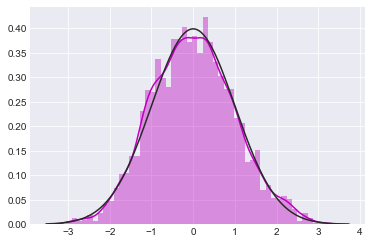

In [60]:
import scipy
sns.distplot(scipy.stats.zscore(bootstrapped["neuron50"]), color='m', fit=stats.norm);

## TODO: for `is_neuron_selective()`, make sure implementation is sound, write-up documentation, and move to analysis_utils.py

In [ ]:
def is_neuron_selective(bootstrapped_df, real_d_df, neuron, behavior_name, hi_percentile, lo_percentile):
    """ Classifies a given neuron as selective or non-selective
    
    Args:
    
    Returns:
    """
    if real_d_df[neuron]['d'] >= np.percentile(bootstrapped_df[neuron], hi_percentile):
        return behavior_name
    elif real_d_df[neuron]['d'] <= np.percentile(bootstrapped_df[neuron], lo_percentile):
        return "Non-" + behavior_name
    else: 
        return "Non-selective"

In [ ]:
is_neuron_selective(bootstrapped, real_d_df, "neuron6", "ClosedArms", 87.5, 5)

## TODO: For `classify_neurons_for_beh()`, make sure implementation is sound, write-up documentation, and move to analysis_utils.py

In [ ]:
def classify_neurons_for_beh(bootstrapped_df, real_d_df, behavior_name, hi_percentile, lo_percentile):
    """Classifies all neurons for one mouse as either selective or non-selective
    
    Args:
    
    Returns:
    """
    neurons_dict = {}
    for neuron in bootstrapped_df.columns:
        neurons_dict[neuron] = is_neuron_selective(bootstrapped_df, real_d_df, neuron, behavior_name, hi_percentile, lo_percentile)

    return neurons_dict

In [ ]:
classify_neurons_for_beh(bootstrapped, real_d_df, "ClosedArms", 87.5, 5)

## TODO: discuss the purpose of `activity_by_neurons()` and `load_Activities_DataFrame()` in order to write up documentation for them.

In [ ]:
au.load_activities_dataframe(result_dataframe, cell_transients_dataframe)